# Segment water in GDL to quantify influence of liquid water on electrochemistry

TODO:

- [x] select only the data containing the GDL and channels
- [x] set up ML and train on one sample
- [x] apply classfier to test sample and segment all
    - [x] align samples with new cropping --> can be independent of membrane segmentation
- [x] allow (de-)selection of features during training
- [ ] allow to add features after most others have been already calculated

In [1]:
# modules
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import dask
import dask.array
from scipy import ndimage
from skimage import filters, feature, io
from skimage.morphology import disk,ball
import sys
from itertools import combinations_with_replacement
import pickle
import imageio
import json
from dask.distributed import Client, LocalCluster
import socket
import subprocess
import gc

# import joblib
# 4 year old tutorial https://www.youtube.com/watch?v=5Zf6DQaf7jk&t=88s does this instead of importing joblib: 
# import dask_ml.joblib
# from sklearn.externals import joblib


from dask import config as cfg
cfg.set({'distributed.scheduler.worker-ttl': None, # Workaround so that dask does not kill workers while they are busy fetching data: https://dask.discourse.group/t/dask-workers-killed-because-of-heartbeat-fail/856, maybe this helps: https://www.youtube.com/watch?v=vF2VItVU5zg?
        'distributed.scheduler.transition-log-length': 100, #potential workaround for ballooning scheduler memory https://baumgartner.io/posts/how-to-reduce-memory-usage-of-dask-scheduler/
         'distributed.scheduler.events-log-length': 100
        })

# get the ML functions, TODO: make a library once it works/is in a stable state
pytrainpath = '/mpc/homes/fische_r/lib/pytrainseg'
cwd = os.getcwd()
os.chdir(pytrainpath)
from filter_functions import image_filter
import training_functions as tfs
from training_functions import train_segmentation
from segmentation import segmentation
pytrain_git_sha = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode().strip()
os.chdir(cwd)

#paths
host = socket.gethostname()
if host == 'mpc2959.psi.ch':
    gitpath = '/mpc/homes/fische_r/lib/co2ely-tomcat'
    toppath = '/mpc/homes/fische_r/NAS/DASCOELY'
    toppathSSD = '/mnt/SSD/fische_r/COELY'
    temppath = '/mnt/SSD/fische_r/tmp'
    temppath_2 = '/mpc/homes/fische_r/NAS/tmp'
    training_path = '/mpc/homes/fische_r/NAS/DASCOELY/processing/05_water_GDL_ML/'
    memlim = '700GB'
elif host == 'mpc2053.psi.ch':
    gitpath = '/mpc/homes/fische_r/lib/co2ely-tomcat'
    toppath = '/mpc/homes/fische_r/NAS/DASCOELY'
    toppathSSD = os.path.join(toppath, 'processing')
    temppath = '/mnt/SSD_2TB_nvme0n1/Robert/tmp/'
    temppath_2 = '/mpc/homes/fische_r/NAS/tmp'
    training_path = '/mpc/homes/fische_r/NAS/DASCOELY/processing/05_water_GDL_ML/'
    memlim = '360GB'
else:
    print('host '+host+' currently not supported')
    
path_02_4D = os.path.join(toppathSSD, '02_registered_3p1D') #h5 with registered data

# fetch githash
cwd = os.getcwd()
os.chdir(gitpath)
git_sha = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode().strip()
githash = subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode().strip()
os.chdir(cwd)

### functionalities for interactive training

In [2]:
from ipywidgets import Image
from ipywidgets import ColorPicker, IntSlider, link, AppLayout, HBox
from ipycanvas import  hold_canvas,  MultiCanvas #RoughCanvas,Canvas,

def on_mouse_down(x, y):
    global drawing
    global position
    global shape
    drawing = True
    position = (x, y)
    shape = [position]

def on_mouse_move(x, y):
    global drawing
    global position
    global shape
    if not drawing:
        return
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        position = (x, y)
    shape.append(position)

def on_mouse_up(x, y):
    global drawing
    global positiondu
    global shape
    drawing = False
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        canvas.fill_polygon(shape)
    shape = []
    
def display_feature(i, TS):
    print('selected '+TS.feature_names[i])
    im = TS.current_feat_stack[:,:,i]
    im8 = im-im.min()
    im8 = im8/im8.max()*255
    return im8

### fire up dask

In [3]:
tempfolder = temppath  #a big SSD is a major adavantage to allow spill to disk and still be efficient. large dataset might crash with too small SSD or be slow with normal HDD
# tempfolder = temppath_2
dask.config.config['temporary-directory'] = tempfolder
# dask.config.config['distributed']['worker']['memory']['recent-to-old-time'] = '200000s'

# here you have the option to use a virtual cluster or even slurm on ra (not attempted yet)
cluster = LocalCluster(dashboard_address=':35000', memory_limit = memlim, n_workers=1) #settings optimised for mpc2959, play around if needed, if you know nothing else is using RAM then you can almost go to the limit
# maybe less workers with more threads makes better use of shared memory 

# scheduler_port = 'tcp://129.129.188.222:8786' #<-- if scheduler on mpc2959; scheduler on mpc2053 -> 'tcp://129.129.188.248:8786'
# cluster = scheduler_port

client = Client(cluster)
client.amm.start()
print('Dashboard at '+client.dashboard_link)

2023-05-16 09:28:37,202 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/SSD/fische_r/tmp/dask-worker-space/worker-aqx4i1f3', purging
/mpc/homes/fische_r/miniconda3/lib/python3.10/contextlib.py:142: UserWarning: Creating scratch directories is taking a surprisingly long time. (3.69s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


Dashboard at http://127.0.0.1:35000/status


## Test ROI selection

In [4]:
# sample = '4'

In [5]:
# # file = '01_'+sample+'_rotated_3p1D.nc'
# file = '02_'+sample+'_registered_3p1D.nc'
# imagepath = os.path.join(path_02_4D, file)
# data = xr.open_dataset(imagepath)
# images = [im for im in data.keys() if im[3:7] == 'imag']
# images.sort()

In [6]:
# im300 = data[images[4]][:,:,300].data

In [7]:
# plt.imshow(im300[50:-50,50:370], cmap='gray', vmin=10000, vmax=15000)

In [8]:
# data.close()

In [9]:
## individual cropping appears to be require for a good ROI for all samples, use same with and height!!

In [10]:
training_path

'/mpc/homes/fische_r/NAS/DASCOELY/processing/05_water_GDL_ML/'

In [11]:
# height = 750
# width = 340
# a = 0
# b = a+height
# c = 30
# d = c + width

# crop_dict = {}
# crop_dict['1'] = (120, 120+height, 10, 10+width) # sample 1 should be aligned by rotation
# crop_dict['3II'] = (5, 5+height, 0, width)
# crop_dict['3III'] = (80, 80+height, 20, 20+width)
# crop_dict['4'] = (40, 40+height, 40, 40+width)
# crop_dict['4II'] = (0, 0+height, 10, 10+width)
# crop_dict['5II'] = (25, 25+height, 15, 15+width)
# crop_dict['5'] = (57, 57+height, 10, 10+width)
# crop_dict['6'] = (105, 105+height, 30, 30+width)
# crop_dict['7x'] = (70, 70+height, 15, 15+width)
# crop_dict['8x'] = (0, 0+height, 25, 25+width)

# samplesall = ['1', '3II', '3III', '4', '4II', '5II', '5', '6', '7x', '8x']

# if not os.path.exists(training_path):
#     os.mkdir(training_path)

# jsonpath = os.path.join(training_path, 'cathode_cropping_and_aligning.json')
# with open(jsonpath, "w") as outfile:
#     json.dump(crop_dict, outfile,indent = 4)

# # samplesall = samplesall[6:10]

# for sample in samplesall:
#     (a1,b1,c1,d1) = (a,b,c,d)
#     if sample in crop_dict.keys():
#         (a1,b1,c1,d1) = crop_dict[sample]
#     file = '02_'+sample+'_registered_3p1D.nc'
#     imagepath = os.path.join(path_02_4D, file)
#     data = xr.open_dataset(imagepath)
#     images = [im for im in data.keys() if im[3:7] == 'imag']
#     images.sort()
#     im300 = data[images[6]][:,:,300].data
#     im0 = data[images[6]][:,:,50].data
#     imfin = data[images[6]][:,:,-50].data
#     data.close()
#     fig, axs = plt.subplots(1,3)
#     axs[0].imshow(im300[a1:b1,c1:d1], cmap='gray', vmin=10000, vmax=15000)
#     axs[1].imshow(im0[a1:b1,c1:d1], cmap='gray', vmin=10000, vmax=15000)
#     axs[2].imshow(imfin[a1:b1,c1:d1], cmap='gray', vmin=10000, vmax=15000)
#     print(imfin.shape, imfin[a1:b1,c1:d1].shape)
    
#     for ax in axs:
#         ax.vlines(20,0,height-1,'w', linestyle='--')
#         ax.hlines(40,0,width-1,'w', linestyle='--')
    
#     plt.title(sample +' '+ images[4])
    

## Data preparation

### create dask array

In [12]:
sample = '4'
file = '02_'+sample+'_registered_3p1D.nc'
imagepath = os.path.join(path_02_4D, file)
data = xr.open_dataset(imagepath)
images = [im for im in data.keys() if im[3:7] == 'imag']
images.sort()

In [13]:
t_utc = data['t_utc'].data
time = data['time'].data

In [14]:
# with obtained cropping data
jsonpath = os.path.join(training_path, 'cathode_cropping_and_aligning.json')
crop_dict = json.load(open(jsonpath, 'r'))

(a,b,c,d) = crop_dict[sample]
(e,f) = (50,-50)

#corrections to crop coordinates
# f = e+1750
# e = e+100

##### define border to crop to GDL

In [15]:
test_im1 = data[images[2]][a:b, c:d, e:f].data
test_im2 = data[images[-5]][a:b, c:d, e:f].data

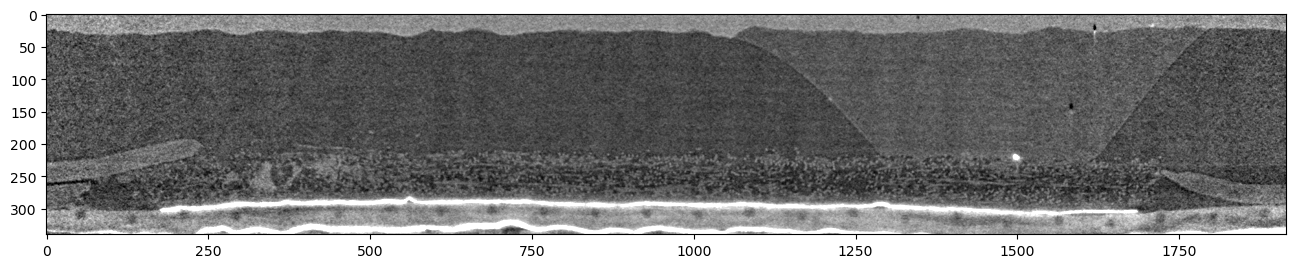

In [16]:
GDL_crop = 0
plt.figure(figsize=(16,9))
plt.imshow(test_im1[600,GDL_crop:, :], vmin =10000, vmax=15000, cmap='gray')

In [17]:
shp = data[images[4]][a:b, c:d, e:f].shape
# shp = data[images[4]][a:b, c+GDL_crop:d, e:f].shape
shp = shp + (len(images),)
print(shp, test_im1[:,GDL_crop:, :].shape)

(750, 340, 1916, 71) (750, 340, 1916)


In [18]:
im = np.zeros(shp, dtype = np.uint16)

In [19]:
# with obtained cropping data
for i in range(shp[-1]):
    if i%10==0:
        print(i)
    # im[...,i] = data[images[i]][a:b, c:d, e:f].data
    im[...,i] = data[images[i]][a:b, c+GDL_crop:d, e:f].data

0
10
20
30
40
50
60
70


In [20]:
chunk_space = 36
da = dask.array.from_array(im, chunks = (chunk_space,chunk_space,chunk_space,len(images)))

In [21]:
da

dask.array<array, shape=(750, 340, 1916, 71), dtype=uint16, chunksize=(36, 36, 36, 71), chunktype=numpy.ndarray>

In [22]:
del im
gc.collect() 

68

In [23]:
data.close()

### get data into image filter class

In [24]:
# TODO: include this routine into pytrainseg

IF = image_filter(sigmas = [2,4,6])# , sigma_0_derivatives=True) #old default settings
IF.data = da
shp = da.shape
coords = {'x': np.arange(shp[0]), 'y': np.arange(shp[1]), 'z': np.arange(shp[2]), 'time': np.arange(shp[3])}
IF.original_dataset = xr.Dataset({'tomo': (['x','y','z','time'], da)},
                                 coords = coords
                                )
# IF.data = IF.data.rechunk('auto')

### prepare features

In [25]:
IF.prepare()

In [26]:
IF.stack_features()

In [27]:
IF.compute_time_independent_features()

2023-05-16 09:44:20,911 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [28]:
IF.feature_stack

dask.array<stack, shape=(750, 340, 1916, 71, 64), dtype=float64, chunksize=(36, 36, 36, 71, 1), chunktype=numpy.ndarray>

In [29]:
IF.make_xarray_nc()

## Training

### set up objects

In [30]:
# quick fix: copy full feature set and cast selection into TS.training_dict
# TODO: select for training without copying

def features_to_keep(feat_length, features_to_remove):
    ids = np.ones(feat_length, dtype=bool)
    for feat in features_to_remove:
        ids[feat] = False
    return ids

def ignore_feat_per_slice(entry, ids):
    truth = entry[1]
    feats = entry[0]
    feats = feats[:,ids]
    return (feats, truth)

def ignore_features(TS, features_to_remove = []):
    if TS.training_dict_full is None:
        TS.combined_feature_names_full = TS.combined_feature_names.copy()
        TS.training_dict_full =  TS.training_dict.copy()
        
        
    ids = features_to_keep(len(TS.combined_feature_names_full), features_to_remove)
    temp_dict = {}
    for key in TS.training_dict_full:
        entry = TS.training_dict_full[key]
        temp_dict[key] = ignore_feat_per_slice(entry, ids)
    TS.training_dict = temp_dict
    TS.combined_feature_names = np.array(TS.combined_feature_names_full)[ids]
    
    return TS, ids

In [31]:
training_path_sample = os.path.join(training_path, sample)
if not os.path.exists(training_path_sample):
    os.mkdir(training_path_sample)

In [32]:
TS = train_segmentation(training_path=training_path_sample)

In [33]:
# TS.training_dict_full = {}

In [34]:
TS.import_lazy_feature_data(IF.result, IF.original_dataset)

In [35]:
IF.combined_feature_names = list(IF.feature_names) + list(IF.feature_names_time_independent)

In [36]:
TS.combined_feature_names = IF.combined_feature_names

In [37]:
TS.combined_feature_names

['diff_to_first_',
 'diff_to_last_',
 'Gaussian_4D_Blur_2.0',
 'Gaussian_4D_Blur_4.0',
 'Gaussian_4D_Blur_6.0',
 'diff_of_gauss_4D_4.0_2.0',
 'diff_of_gauss_4D_6.0_2.0',
 'diff_of_gauss_4D_6.0_4.0',
 'Gradient_sigma_2.0_0',
 'Gradient_sigma_2.0_1',
 'Gradient_sigma_2.0_2',
 'Gradient_sigma_2.0_3',
 'hessian_sigma_2.0_00',
 'hessian_sigma_2.0_01',
 'hessian_sigma_2.0_02',
 'hessian_sigma_2.0_03',
 'hessian_sigma_2.0_11',
 'hessian_sigma_2.0_12',
 'hessian_sigma_2.0_13',
 'hessian_sigma_2.0_22',
 'hessian_sigma_2.0_23',
 'hessian_sigma_2.0_33',
 'Gradient_sigma_4.0_0',
 'Gradient_sigma_4.0_1',
 'Gradient_sigma_4.0_2',
 'Gradient_sigma_4.0_3',
 'hessian_sigma_4.0_00',
 'hessian_sigma_4.0_01',
 'hessian_sigma_4.0_02',
 'hessian_sigma_4.0_03',
 'hessian_sigma_4.0_11',
 'hessian_sigma_4.0_12',
 'hessian_sigma_4.0_13',
 'hessian_sigma_4.0_22',
 'hessian_sigma_4.0_23',
 'hessian_sigma_4.0_33',
 'Gradient_sigma_6.0_0',
 'Gradient_sigma_6.0_1',
 'Gradient_sigma_6.0_2',
 'Gradient_sigma_6.0_3',
 

### interactive training

#### check for existing training sets

In [38]:
existing_sets = os.listdir(os.path.join(training_path_sample, 'label_images'))
existing_sets.sort()
existing_sets

['label_image_x_157_time_5_.tif',
 'label_image_x_172_time_17_.tif',
 'label_image_x_172_time_2_.tif',
 'label_image_x_252_time_0_.tif',
 'label_image_x_264_time_29_.tif',
 'label_image_x_270_time_50_.tif',
 'label_image_x_307_time_25_.tif',
 'label_image_x_368_time_45_.tif',
 'label_image_x_456_time_0_.tif',
 'label_image_x_503_time_15_.tif',
 'label_image_x_531_time_50_.tif',
 'label_image_y_241_time_0_.tif',
 'label_image_y_245_time_8_.tif',
 'label_image_y_250_time_23_.tif',
 'label_image_y_250_time_33_.tif',
 'label_image_y_255_time_20_.tif',
 'label_image_y_255_time_40_.tif',
 'label_image_y_255_time_64_.tif',
 'label_image_y_270_time_47_.tif',
 'label_image_y_280_time_57_.tif',
 'label_image_y_71_time_27_.tif',
 'label_image_z_307_time_0_.tif',
 'label_image_z_307_time_10_.tif',
 'label_image_z_307_time_25_.tif',
 'label_image_z_320_time_10_.tif',
 'label_image_z_320_time_30_.tif',
 'label_image_z_320_time_45_.tif',
 'label_image_z_468_time_11_.tif',
 'label_image_z_546_time_0_.

In [39]:
training_path

'/mpc/homes/fische_r/NAS/DASCOELY/processing/05_water_GDL_ML/'

In [40]:
# you can load a compatible pickled training dict, check feature names
TS.training_dict = pickle.load(open(os.path.join(TS.training_path, pytrain_git_sha+'_training_dict.p'),'rb'))

In [ ]:
TS.training_dict

#### re-train with existing label sets. clear the training dictionary if necessary (training_dict)

In [41]:
TS.train()

training with existing label images
label_image_z_546_time_0_.tif
label_image_y_255_time_40_.tif already done
label_image_z_307_time_25_.tif already done
label_image_x_157_time_5_.tif already done
label_image_y_71_time_27_.tif already done
label_image_x_270_time_50_.tif already done
label_image_x_456_time_0_.tif already done
label_image_z_320_time_10_.tif already done
label_image_x_307_time_25_.tif
label_image_z_564_time_0_.tif already done
label_image_z_320_time_30_.tif already done
label_image_x_264_time_29_.tif already done
label_image_y_280_time_57_.tif already done
label_image_y_250_time_23_.tif already done
label_image_x_172_time_17_.tif


2023-05-16 09:45:00,371 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-05-16 09:45:14,621 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-05-16 09:45:35,188 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-05-16 09:46:04,314 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-05-16 09:49:22,459 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-05-16 09:50:54,694 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-05-16 09:52:31,246 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-05-16 09:53:45,077 - distributed.utils_perf - WARNING - full garbage collections took

label_image_x_503_time_15_.tif


2023-05-16 11:00:29,991 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-05-16 11:02:55,018 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-05-16 11:04:08,520 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-05-16 11:21:07,596 - distributed.worker.memory - WARNING - gc.collect() took 11.310s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-05-16 11:34:20,746 - distributed.worker.memory - WARNING - gc.collect() took 12.740s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.


label_image_y_255_time_20_.tif


2023-05-16 11:58:42,997 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-16 12:00:56,045 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-16 12:03:19,904 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-16 12:05:08,338 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-05-16 12:40:23,700 - distributed.worker.memory - WARNING - gc.collect() took 15.942s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-05-16 12:54:44,026 - distributed.worker.memory - WARNING - gc.collect() took 16.627s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-05-16 13:06:40,

label_image_y_250_time_33_.tif


KeyboardInterrupt: 

#### import training dict of other samples 
(replace sample name and repeat for multiple samples), if necessary check features for overlap

In [39]:
oldsample = '4'
oldgitsha = 'ec4415d'
if oldsample == '4':
    training_dict_old = pickle.load(open(os.path.join(toppathSSD, '05_water_GDL_ML', '4', 'ec4415d_training_dict_without_loc_feat.p'), 'rb'))
else:
    training_dict_old = pickle.load(open(os.path.join(training_path, oldsample,  oldgitsha+'_training_dict.p'),'rb'))
oldfeatures = pickle.load(open(os.path.join(training_path, oldsample,  oldgitsha+'_feature_names.p'),'rb'))
    
    # pickle.dump(TS.training_dict, open(os.path.join(TS.training_path, pytrain_git_sha+'_training_dict.p'),'wb'))
# pickle.dump(TS.feature_names, open(os.path.join(TS.training_path, pytrain_git_sha+'_feature_names.p'),'wb'))

for key in training_dict_old.keys():
    TS.training_dict[oldsample+key] = training_dict_old[key]

#### suggest a new training coordinate
currently retraining with new feature stack not properly implemented. Workaround: choose from the exiting training sets and train with them (additional labeling optional)

In [42]:
TS.suggest_training_set()

You could try  x = 55  and  z = 1058
However, please sort it like the original xyztimetime_0feature


In [70]:
c1 = 'y'
p1 = 240
c2 = 'time'
p2 = 14

In [71]:
TS.load_training_set(c1, p1, c2, p2)
im8 = TS.current_im8

In [72]:
# TS.get_slice_feat_stack()

In [73]:
feat_data = TS.feat_data
[c1,p1,c2,p2] = TS.current_coordinates
newslice = True

if c1 == 'x' and c2 == 'time':
    feat_stack = feat_data['feature_stack'].sel(x = p1, time = p2).data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(x = p1, time_0 = 0).data
elif c1 == 'x' and c2 == 'y':
    feat_stack = feat_data['feature_stack'].sel(x = p1, y = p2).data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(x = p1, y = p2).data
elif c1 == 'x' and c2 == 'z':
    feat_stack = feat_data['feature_stack'].sel(x = p1, z = p2).data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(x = p1, z = p2).data
elif c1 == 'y' and c2 == 'z':
    feat_stack = feat_data['feature_stack'].sel(y = p1, z = p2).data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(y = p1, z = p2).data
elif c1 == 'y' and c2 == 'time':
    feat_stack = feat_data['feature_stack'].sel(y = p1, time = p2).data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(y = p1, time_0 = 0).data
elif c1 == 'z' and c2 == 'time':
    feat_stack = feat_data['feature_stack'].sel(z = p1, time = p2).data
    feat_stack_t_idp = feat_data['feature_stack_time_independent'].sel(z = p1, time_0 = 0).data


TS.current_feat_stack = dask.array.concatenate([feat_stack, feat_stack_t_idp], axis = 2)

if type(TS.current_feat_stack) is not np.ndarray:
    TS.current_computed = False

#### canvas for labeling

In [74]:
# imm = mean[:,p1,:].copy()
# im8m= imm-imm.min()
# im8m = im8m/im8m.max()*255
# im8 = im8m

In [92]:
alpha = 0.15
zoom1 = (-500,-1)
zoom2 = (600,1400)

zoom1 = (0, -1)
zoom2 = (0, -1)

# im8 = TS.current_im8
#trick: use gaussian_time_4_0 to label static phases ()
# im8 = display_feature(-2, TS)
# im8 = display_feature(-20, TS)
# print(IF.combined_feature_names[-20])
print('original shape: ',im8.shape)
im8_display = im8.copy()[zoom1[0]:zoom1[1], zoom2[0]:zoom2[1]]
print('diyplay shape : ',im8_display.shape,' at: ', (zoom1[0], zoom2[0]))

resultim = TS.current_result.copy()

resultim_display = resultim[zoom1[0]:zoom1[1], zoom2[0]:zoom2[1]]


width = im8_display.shape[1]
height = im8_display.shape[0]
Mcanvas = MultiCanvas(4, width=width, height=height)
background = Mcanvas[0]
resultdisplay = Mcanvas[2]
truthdisplay = Mcanvas[1]
canvas = Mcanvas[3]
canvas.sync_image_data = True
drawing = False
position = None
shape = []
image_data = np.stack((im8_display, im8_display, im8_display), axis=2)
background.put_image_data(image_data, 0, 0)
slidealpha = IntSlider(description="Result overlay", value=0.15)
resultdisplay.global_alpha = alpha #slidealpha.value
if np.any(resultim>0):
    result_data = np.stack((255*(resultim_display==0), 255*(resultim_display==1), 255*(resultim_display==2)), axis=2)
else:
    result_data = np.stack((0*resultim, 0*resultim, 0*resultim), axis=2)
resultdisplay.put_image_data(result_data, 0, 0)
canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)
picker = ColorPicker(description="Color:", value="#ff0000") #red
# picker = ColorPicker(description="Color:", value="#0000ff") #blue
# picker = ColorPicker(description="Color:", value="#00ff00") #green

link((picker, "value"), (canvas, "stroke_style"))
link((picker, "value"), (canvas, "fill_style"))
link((slidealpha, "value"), (resultdisplay, "global_alpha"))

HBox((Mcanvas,picker))
# HBox((Mcanvas,)) #picker 

original shape:  (750, 1916)
diyplay shape :  (749, 1915)  at:  (0, 0)


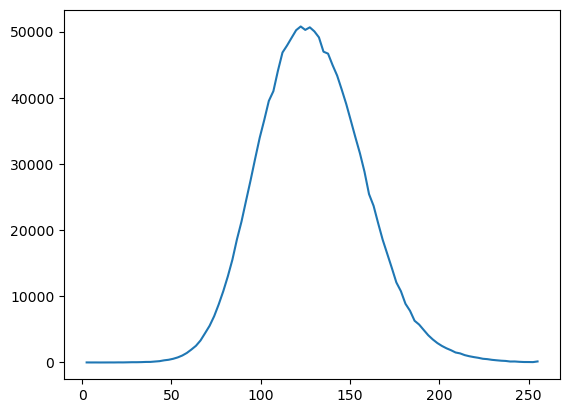

In [81]:
tfs.plot_im_histogram(im8)
# im8 = TS.current_im8
# im8 = tfs.adjust_image_contrast(im8,20,200)

#### inspect labels and training progress

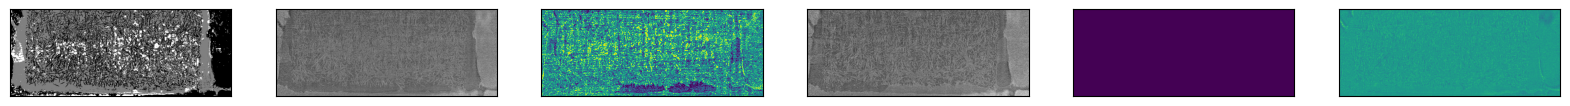

In [93]:
fig, axes = plt.subplots(1,6, figsize=(20,10))
axes[0].imshow(TS.current_result, 'gray')
axes[1].imshow(TS.current_im8, 'gray')

# TS.current_diff_im = TS.current_im-TS.current_first_im
# TS.current_diff_im = TS.current_diff_im/TS.current_diff_im.max()*255
axes[2].imshow(-TS.current_diff_im)#,vmin=6e4)
# axes[3].imshow(im8old, 'gray')
axes[3].imshow(TS.current_first_im, 'gray')
axes[4].imshow(TS.current_truth)
if TS.current_computed:
    axes[5].imshow(TS.current_feat_stack[:,:,-10])
else:
    axes[5].imshow(TS.current_result, 'gray')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#### update training set if labels are ok

In [84]:
label_set = canvas.get_image_data()

TS.current_truth[zoom1[0]:zoom1[1], zoom2[0]:zoom2[1]][label_set[:,:,0]>0] = 1
TS.current_truth[zoom1[0]:zoom1[1], zoom2[0]:zoom2[1]][label_set[:,:,1]>0] = 2
TS.current_truth[zoom1[0]:zoom1[1], zoom2[0]:zoom2[1]][label_set[:,:,2]>0] = 4

imageio.imsave(TS.current_truthpath, TS.current_truth)

#### (already removed from filter functions, not necessary to remove anymore) ignore pixel location as feature as this can be dangerous 
try ignoring full temp mean as clf relies too much on it

In [85]:
# TODO: find feature index by name
# loc_feats = [-4, -5, -6]

In [86]:
# ignore features in training dict
# TS, ids = ignore_features(TS, loc_feats)
# ignore features in current feature set
#  risky workaround for now
# currfeatpath = '/mnt/SSD/fische_r/tmp/temp_curr_feat.p'
# pickle.dump(TS.current_feat_stack, open(currfeatpath, 'wb'))
# if newslice:
#     TS.current_feat_stack = TS.current_feat_stack[:,:,ids]
#     newslice = False

#### train!

In [87]:
# TODO: see, if training gets slow for many label sets, currently stored in training_dict and read as loop. or if it is just the larger amount of data
TS.train_slice()

now actually calculating the features


2023-03-29 10:43:42,902 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-29 10:46:50,886 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:47:32,421 - distributed.worker.memory - WARNING - gc.collect() took 1.027s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-03-29 10:49:51,644 - distributed.worker.memory - WARNING - gc.collect() took 1.240s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-03-29 10:49:52,590 - distributed.worker.memory - WARNING - gc.collect() took 1.523s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2023-03-29 10:50:09,993 - distributed.worker.memory -

feat_stack is not a numpy array! check why
training and classifying


In [421]:
# # load exisiting classifier and segment one slice
# clf = pickle.load(open(os.path.join(training_path, 'classifier.p'), 'rb'))
# feat = TS.current_feat_stack.compute()
# shp = feat[...,0].shape
# num_feat = feat.shape[-1]
# feat = feat.reshape(-1,num_feat)
# seg = clf.predict(feat)
# seg = seg.reshape(shp).astype(np.uint8)
# plt.figure(figsize=(16,9))
# plt.imshow(seg, cmap='gray_r')

In [422]:
# plt.figure(figsize=(16,9))
# plt.imshow(im8, cmap='gray')

#### go back until happy

#### check on training progress by plausible feature importance

Text(0, 0.5, 'importance')

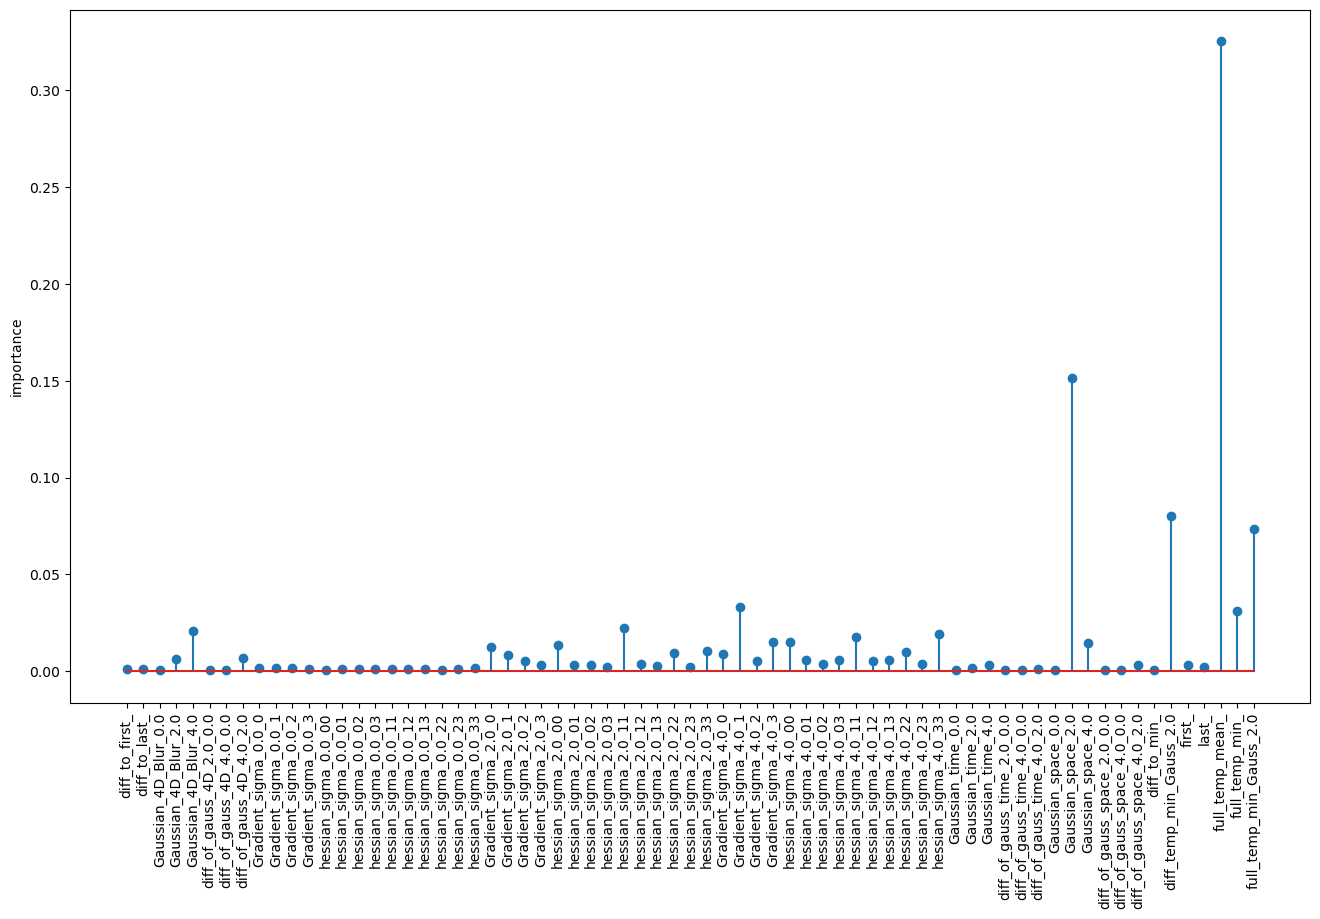

In [94]:
plt.figure(figsize=(16,9))
plt.stem(TS.combined_feature_names, TS.clf.feature_importances_,'x')
plt.xticks(rotation=90)
plt.ylabel('importance') 
# plt.xticks(rotation = 60)

### when done, maybe save the classifier and optional the training dict (avoids recalculating the training sets, but might be large)

In [43]:
# TS.pickle_classifier()
pickle.dump(TS.training_dict, open(os.path.join(TS.training_path, pytrain_git_sha+'_training_dict.p'),'wb'))
pickle.dump(TS.combined_feature_names, open(os.path.join(TS.training_path, pytrain_git_sha+'_feature_names.p'),'wb'))

In [46]:
TS.training_dict_full

{'label_image_y_255_time_40_.tif': (array([[-1.46428571e+02, -4.71285714e+02,  1.71676120e-01, ...,
           1.11674225e+04,  1.06050000e+04,  1.70411936e-01],
         [ 1.54714286e+02, -1.69714286e+02,  1.72399418e-01, ...,
           1.13587042e+04,  1.08410000e+04,  1.71066865e-01],
         [-1.65000000e+02, -3.60142857e+02,  1.71660520e-01, ...,
           1.10823803e+04,  1.03730000e+04,  1.70895247e-01],
         ...,
         [ 1.56428571e+02,  2.81285714e+02,  1.78094529e-01, ...,
           1.19940141e+04,  1.14850000e+04,  1.78078066e-01],
         [ 1.63285714e+02,  1.47000000e+02,  1.77728446e-01, ...,
           1.19303803e+04,  1.13000000e+04,  1.77728446e-01],
         [-2.08571429e+02, -3.50142857e+02,  1.76900536e-01, ...,
           1.15639014e+04,  1.10180000e+04,  1.76805548e-01]]),
  array([0., 0., 0., ..., 2., 2., 2.])),
 'label_image_z_307_time_25_.tif': (array([[-2.46142857e+02, -3.74142857e+02,  1.76275724e-01, ...,
           1.18232958e+04,  1.10610000e+0

In [103]:
TS.training_path

'/mpc/homes/fische_r/NAS/DASCOELY/processing/05_water_GDL_ML/1'

In [50]:
pytrain_git_sha

'ec4415d'

## Segmentation of full data set

remember that you removed features to train the clf

In [37]:
from segmentation import segmentation

In [38]:
classifier_path=os.path.join(training_path, 'classifier.p')
SM = segmentation(training_path = training_path, classifier_path=classifier_path)

In [39]:
# SM.import_lazy_feature_data(IF.result)
# SM.import_classifier(TS.clf)
SM.clf = pickle.load(open(os.path.join(training_path, 'classifier.p'), 'rb'))

In [40]:
clf = SM.clf
clf.n_jobs = 64

if host == 'mpc2053.psi.ch':
    clf.n_jobs = 20

In [41]:
#TODO create result as a stream for every feature set of chunks, i.e stack of 67 feature chunks
# clf = TS.clf
# clf.n_jobs = 32

In [42]:
# loc_feats = [-4, -5, -6]
# ids = np.ones(72, dtype=bool)
# for f in loc_feats:
#     ids[f] = False

In [43]:
# ids

### merge time-independent features

In [44]:
test = dask.array.stack([TS.feat_data['feature_stack_time_independent'][:,:,:,0,:]]*da.shape[-1], axis=-2)

2023-04-28 08:57:28,625 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-04-28 08:57:33,885 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


In [45]:
test

dask.array<stack, shape=(750, 130, 1700, 88, 5), dtype=float64, chunksize=(32, 32, 32, 1, 1), chunktype=numpy.ndarray>

In [46]:
feat = dask.array.concatenate([TS.feat_data['feature_stack'], test], axis=-1)

2023-04-28 08:57:55,416 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 08:58:41,121 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 08:59:32,401 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:00:31,800 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:01:44,643 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:03:17,745 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


In [47]:
# feat = feat[...,ids]

In [48]:
feat

dask.array<concatenate, shape=(750, 130, 1700, 88, 69), dtype=float64, chunksize=(32, 32, 32, 1, 1), chunktype=numpy.ndarray>

### check aligment of chunks and select suitable "super-chunk" shape to split calculation in parts, example below

In [49]:
750*2.3

1724.9999999999998

In [50]:
350/50

7.0

In [51]:
i = 12
j = i
# j = 3
dim1 = 64#better use multiple of chunk size !?
dim2 = int(2.3*dim1)
feat[i*dim1:(i+1)*dim1,:,j*dim2:(j+1)*dim2,:,:] #select all features and all time steps, but you are free in space; als large as possible and as small as necessary. limit is the available RAM to collect the dask result

dask.array<getitem, shape=(0, 130, 0, 88, 69), dtype=float64, chunksize=(0, 32, 0, 1, 1), chunktype=numpy.ndarray>

In [52]:
# segs = np.zeros(feat.shape[:4], dtype=np.uint8)
segs = pickle.load(open(os.path.join(training_path,'segs.p'), 'rb'))

2023-04-28 09:06:48,538 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:07:43,656 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-04-28 09:07:45,739 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-04-28 09:07:48,023 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-04-28 09:07:50,311 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-04-28 09:07:52,682 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-04-28 09:07:55,129 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-04-28 09:07:57,693 - distributed.utils_perf - WARNING - full garbage collections took

In [53]:
# import gc
client.run(gc.collect)
gc.collect()

2023-04-28 09:08:05,439 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-28 09:08:25,753 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


101

In [54]:
import ctypes
def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

In [55]:
limit = 12
# TODO: Workaround: write intermediates to disk and restart dask client/scheduler/workers to get rid of unmanaged memory
# possible solution: do data handling on mpc2053 and calculations on mpc2959 -> leaves some RAM --> gc.collect() not necessary anymore
# appearantly starts to become critical after 12 iteratons
# from i=7, j=10 already done
# TODO write i and j to file to track progress even when closing jupyter
for i in range(1,limit):
    pickle.dump(segs, open(os.path.join(training_path,'segs_temp.p'), 'wb'))
    
    print(str(i+1)+'/'+str(limit))
    # plt.figure()
    # plt.imshow(segs[:,100,:, 50])
    # plt.savefig(os.path.join(training_path, sample+'_'+str(i)+'_progress.png'))
    # client.run(gc.collect)
    # client.run(trim_memory)
    start = 0
    if i == 1:
        start = 8
    for j in range(start,limit):
        gc.collect() 
        client.run(gc.collect)
        client.run(trim_memory)
        print(j)
        #with joblib.parallel_backend('dask'):
        part = feat[i*dim1:(i+1)*dim1,:,j*dim2:(j+1)*dim2,:,:] #.persist() #compute() may blow up the memory ?! https://stackoverflow.com/questions/73770527/dask-compute-uses-twice-the-expected-memory
        if 0 in part.shape:
            print('hit the edge (one dimension 0), ignore')
            continue
        part = part.compute()
        # try to release old unmanaged memory
        client.run(gc.collect)
        client.run(trim_memory)

        shp = part.shape
        num_feat = part.shape[-1]  
        part = part.reshape(-1,num_feat)

        psplit = int(part.shape[0]/2)

        print('create part 1')
        part1 = part[:psplit,:]
        print('create part 2')
        part2 = part[psplit:,:]
        print('segmenting 1')

        # with joblib.parallel_backend('dask'):
        seg1 = clf.predict(part1).astype(np.uint8)
        del part1
        print('segmenting 2')
        # with joblib.parallel_backend('dask'):
        seg2 = clf.predict(part2).astype(np.uint8)
        print('wrap results')
        del part2
        del part
        # gc.collect()

        seg = np.concatenate([seg1,seg2])
        print(seg.shape)
        del seg1
        del seg2

        seg = seg.reshape(shp[:4])  #this step needs a lot of RAM ?! appearantly not
    
    # not sure if this switch cases are necessary
        if i < limit-1 and j < limit-1:
            segs[i*dim1:(i+1)*dim1,:,j*dim2:(j+1)*dim2,:] = seg
        elif not i < limit-1 and j < limit-1:
            segs[i*dim1:,:,j*dim2:(j+1)*dim2,:] =  seg
        elif not j < limit-1 and i < limit-1:
            segs[i*dim1:(i+1)*dim1,:,j*dim2:,:] =  seg
        else:
            segs[i*dim1:,:,j*dim2:,:] = seg
            
        del seg

2023-04-28 09:08:27,911 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-04-28 09:08:32,501 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 09:08:36,089 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 09:08:39,271 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 09:08:43,344 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 09:08:47,329 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 09:08:51,357 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 09:08:56,011 - distributed.utils_perf - WARNING - full garbage collections took

1/12


2023-04-28 09:09:25,644 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 09:09:26,978 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


0


2023-04-28 09:11:01,156 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:12:35,274 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 09:12:41,381 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:13:15,229 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 09:13:54,218 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-04-28 09:14:01,552 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-04-28 09:14:09,541 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-04-28 09:14:17,976 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 09:33:50,338 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-04-28 09:33:54,598 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


1


2023-04-28 09:37:46,191 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-04-28 09:38:27,164 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:38:54,606 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:39:25,908 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:39:58,196 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:40:33,729 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:41:10,943 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:41:50,088 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 09:52:24,671 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 09:52:29,122 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


2


2023-04-28 09:56:18,982 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 09:57:00,346 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:57:28,002 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:58:00,087 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:58:33,375 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 09:59:09,327 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 09:59:45,641 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 10:00:25,569 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 10:11:00,336 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 10:11:04,810 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


3


2023-04-28 10:14:56,290 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 10:15:38,548 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 10:16:05,579 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 10:16:36,660 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 10:17:09,639 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 10:17:45,001 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 10:18:22,414 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 10:19:03,250 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 10:29:48,016 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 10:29:52,217 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


4


2023-04-28 10:33:41,743 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 10:34:22,697 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 10:34:51,289 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 10:35:19,666 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 10:35:53,907 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 10:36:29,200 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 10:37:07,892 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 10:37:46,968 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 10:48:11,129 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 10:48:15,871 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


5


2023-04-28 10:52:05,326 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 10:52:47,845 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 10:53:15,818 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 10:53:50,242 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 10:54:24,344 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 10:54:59,402 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 10:55:37,198 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 10:56:17,524 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 11:07:03,483 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 11:07:07,776 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6


2023-04-28 11:10:58,040 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 11:11:39,632 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 11:12:06,874 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 11:12:39,453 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 11:13:13,249 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 11:13:49,158 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 11:14:27,064 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 11:15:07,297 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 11:25:48,682 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 11:25:53,441 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7


2023-04-28 11:29:44,829 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 11:30:26,363 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 11:30:53,563 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 11:31:26,302 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 11:31:59,741 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 11:32:35,852 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 11:33:15,321 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 11:33:55,385 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 11:44:40,915 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 11:44:45,410 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


8


2023-04-28 11:48:37,955 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 11:49:19,274 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 11:49:46,124 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 11:50:18,363 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 11:50:51,032 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 11:51:26,612 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 11:52:04,024 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 11:52:43,596 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 12:03:31,389 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 12:03:36,150 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


9


2023-04-28 12:07:28,107 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 12:08:10,790 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 12:08:39,711 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 12:09:09,877 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 12:09:45,295 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 12:10:25,262 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 12:11:02,139 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 12:11:40,774 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 12:22:03,472 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 12:22:08,496 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


10


2023-04-28 12:26:01,489 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 12:26:46,874 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 12:27:15,977 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 12:27:48,595 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 12:28:21,703 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 12:28:58,852 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 12:29:36,198 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 12:30:15,999 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 12:41:10,472 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 12:41:14,911 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


11


2023-04-28 12:45:03,101 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-04-28 12:45:44,089 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 12:46:14,342 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 12:46:45,671 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 12:47:19,015 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 12:47:52,533 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 12:48:30,022 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 12:49:09,080 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 13:15:58,072 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 13:16:02,683 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


1


2023-04-28 13:19:59,444 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 13:20:41,630 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 13:21:10,911 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 13:21:39,342 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 13:22:14,396 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 13:22:51,258 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 13:23:30,507 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 13:24:10,381 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 13:35:13,229 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 13:35:17,909 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


2


2023-04-28 13:39:14,703 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 13:39:57,621 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 13:40:26,990 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 13:40:56,744 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 13:41:34,049 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 13:42:11,988 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 13:42:50,804 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 13:43:31,230 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 13:54:35,278 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 13:54:40,081 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


3


2023-04-28 13:58:34,454 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 13:59:17,889 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 13:59:47,860 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 14:00:18,009 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 14:00:54,121 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 14:01:31,134 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 14:02:09,636 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 14:02:49,887 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 14:13:35,523 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 14:13:40,258 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


4


2023-04-28 14:17:35,143 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 14:18:17,955 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-04-28 14:18:46,786 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-04-28 14:19:15,680 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-04-28 14:19:51,514 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 14:20:25,755 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 14:21:03,917 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 14:21:43,329 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 14:32:29,962 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 14:32:34,324 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


5


2023-04-28 14:36:30,886 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 14:37:13,969 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 14:37:41,245 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 14:38:13,130 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 14:38:46,967 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 14:39:23,051 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 14:40:01,342 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-04-28 14:40:40,535 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 14:51:25,857 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 14:51:30,790 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


6


2023-04-28 14:55:29,831 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 14:56:13,924 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 14:56:43,053 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 14:57:12,522 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 14:57:46,826 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 14:58:22,673 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 14:59:01,253 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 14:59:40,928 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 15:10:36,955 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 15:10:41,352 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


7


2023-04-28 15:14:34,270 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 15:15:15,894 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-04-28 15:15:44,486 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 15:16:13,034 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 15:16:49,559 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 15:17:24,824 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 15:18:03,753 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-04-28 15:18:43,737 - distributed.utils_perf - WARNING - full garbage collections took

create part 1
create part 2
segmenting 1
segmenting 2
wrap results
(107627520,)


2023-04-28 15:29:26,309 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-28 15:29:30,723 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


8


2023-04-28 15:33:25,978 - distributed.core - ERROR - Timed out during handshake while connecting to tcp://127.0.0.1:36551 after 30 s
Traceback (most recent call last):
  File "/mpc/homes/fische_r/miniconda3/lib/python3.10/asyncio/runners.py", line 44, in run
    return loop.run_until_complete(main)
  File "/mpc/homes/fische_r/miniconda3/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    self.run_forever()
  File "/mpc/homes/fische_r/miniconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/mpc/homes/fische_r/miniconda3/lib/python3.10/asyncio/base_events.py", line 1868, in _run_once
    event_list = self._selector.select(timeout)
  File "/mpc/homes/fische_r/miniconda3/lib/python3.10/selectors.py", line 469, in select
    fd_event_list = self._selector.poll(timeout, max_ev)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/mpc/homes/fi

KeyboardInterrupt: 

In [58]:
i

1

In [59]:
j

8

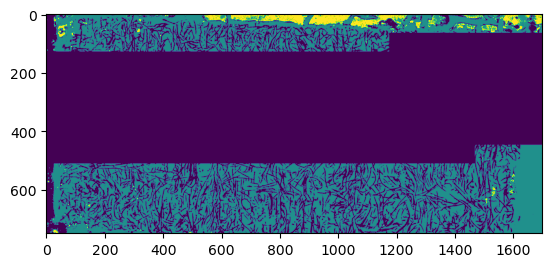

In [57]:
plt.imshow(segs[:,50,:, 20])

In [56]:
pickle.dump(segs, open(os.path.join(training_path,'segs.p'), 'wb'))

2023-04-28 15:34:27,314 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing


### save result to disk

In [62]:
# TODO: include metadata in segmented nc and

shp = segs.shape
segdata = xr.Dataset({'segmented': (['x','y','z','timestep'], segs),
                     't_utc': ('timestep', t_utc),
                     'time': ('timestep', time)},
                               coords = {'x': np.arange(shp[0]),
                               'y': np.arange(shp[1]),
                               'z': np.arange(shp[2]),
                               'timestep': np.arange(shp[3]),
                               'feature': TS.combined_feature_names}
                     )
segdata.attrs = data.attrs.copy()
segdata.attrs['05_ML_cropping'] = [a,b,c,d,e,f]
segdata.attrs['pytrain_git'] = pytrain_git_sha
segdata.attrs['05_coely_gitsha'] = git_sha
segdata.attrs['GDL_crop'] = GDL_crop

In [63]:
segpath = os.path.join(training_path_sample, sample+'water_segmentation.nc')

In [64]:
segdata.to_netcdf(segpath)

In [75]:
# load intermediate result
seg_data = xr.load_dataset(segpath)

In [37]:
segs = seg_data['segmented'].data

In [61]:
segdata

<xarray.Dataset>
Dimensions:    (x: 750, y: 340, z: 1916, timestep: 31, feature: 69)
Coordinates:
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 742 743 744 745 746 747 748 749
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 332 333 334 335 336 337 338 339
  * z          (z) int64 0 1 2 3 4 5 6 7 ... 1909 1910 1911 1912 1913 1914 1915
  * timestep   (timestep) int64 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29 30
  * feature    (feature) <U27 'diff_to_first_' ... 'full_temp_min_Gauss_2.0'
Data variables:
    segmented  (x, y, z, timestep) uint8 0 0 0 2 2 2 0 0 0 ... 0 0 0 0 0 0 0 0 0
    t_utc      (timestep) float64 1.667e+09 1.667e+09 ... 1.667e+09 1.667e+09
    time       (timestep) float64 7.036 6.218 66.42 126.6 ... 759.3 819.5 879.7
Attributes: (12/20)
    name:                                              1
    voxel size:                                        2.75 um
    voxel:                                             2.75e-06
    post rotation cropping coordinates [a:b,c:d,e:f]:  [ 120 1062  320  972  ...
    rotation angle 1:                                  -22
    rotation angle 2:                                  -22
    ...                                                ...
    05_crop_githash:                                   761a49fa1ea416a28344b9...
    git_sha_registration:                              612e92b
    githash_registration:                              612e92b28895745f6b422c...
    05_ML_cropping:                                    [120, 870, 10, 350, 50...
    pytrain_git:                                       e5b2d83
    05_coely_gitsha:                                   1c033ce